### Data-driven prediction of battery cycle life and knee-point

Kristen A. Severson, et al. Data-driven prediction of battery cycle life before capacity degradation, Nature Energy, Vol. 4, 2019, 383-391, https://doi.org/10.1038/s41560-019-0356-8

Kristen A. Severson, et al. Data-driven prediction of battery cycle life before capacity degradation, Supplementary Information, Nature Energy.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import shap
import json

In [2]:
from scipy.stats import pearsonr
from scipy.integrate import simpson

In [3]:
from sklearn import svm
from sklearn.linear_model import ElasticNet, TweedieRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

In [4]:
from processing import (# Import local functions.
    import_dataset, 
    get_cell_stats, get_data_array_stats, get_features_from_data, 
    filter_signal, interpolate_signal, 
    bacon_watts_model, double_bacon_watts_model, fit_bacon_watts_model, 
    get_knee_points, get_knee_onset_points,
)

In [5]:
sns.set_theme(context='paper', style='white', font_scale=1.1, palette='deep')
sns.set_style('ticks', {'xtick.direction':'in', 'ytick.direction':'in'})

### Import dataset

In [6]:
# NOTE: Running this cell can take some time.
matlab_file = '2018-02-20_batchdata_updated_struct_errorcorrect.mat'
bat_dict = import_dataset(matlab_file)

In [7]:
# This is a nested dictionary object.
bat_dict.keys()  # Battery cell id's (batch level).

dict_keys(['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4', 'b1c5', 'b1c6', 'b1c7', 'b1c8', 'b1c9', 'b1c10', 'b1c11', 'b1c12', 'b1c13', 'b1c14', 'b1c15', 'b1c16', 'b1c17', 'b1c18', 'b1c19', 'b1c20', 'b1c21', 'b1c22', 'b1c23', 'b1c24', 'b1c25', 'b1c26', 'b1c27', 'b1c28', 'b1c29', 'b1c30', 'b1c31', 'b1c32', 'b1c33', 'b1c34', 'b1c35', 'b1c36', 'b1c37', 'b1c38', 'b1c39', 'b1c40', 'b1c41', 'b1c42', 'b1c43', 'b1c44', 'b1c45', 'b1c46'])

In [8]:
# Measurement data for each battery cell is comprised of "summary"
# values and full raw data for each cycle under "cycles" variable.
bat_dict['b1c0'].keys()  # Battery cell level variable names.

dict_keys(['Vdlin', 'cycle_life', 'charge_policy', 'summary', 'cycles'])

In [9]:
bat_dict['b1c0']['summary'].keys()  # Summary level variable names.

dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])

In [10]:
bat_dict['b1c0']['cycles'][str(1)].keys()  # Cycles level variable names.

dict_keys(['I', 'Qc', 'Qd', 'Qdlin', 'T', 'Tdlin', 'V', 'dQdV', 't'])

### Processing of cycles data

In [11]:
# Select sample cell ID and a number of cycles to process:
cell = 'b1c20'  # EDIT HERE
no_cycles = 3   # EDIT HERE
cell_stats = get_cell_stats(bat_dict, cell, no_cycles, 'Qdlin')
print(cell_stats)

defaultdict(<class 'list'>, {'min': [-8.229979745722309e-05, -0.0001231600134744703, -6.6962956170627e-05], 'max': [1.0583508028374768, 1.0592912566103287, 1.059046534723112], 'mean': [0.7572970744265232, 0.7610902278784719, 0.7573699466073013], 'std': [0.42302122293007, 0.4231576522729363, 0.42320838854936776], 'mode': [-8.229979745722309e-05, -0.0001231600134744703, -6.6962956170627e-05], 'skew': [-1.035958947532848, -1.0487862719544505, -1.0338411011954878], 'kurt': [-0.7553257019932893, -0.7316502724896798, -0.758606857530502], 'median': [1.0202466260567182, 1.0235131501277488, 1.0204676144543665], 'iqr': 0.6124528116361984, 'auc': [1.1362881984609654, 1.141982948693954, 1.136397082314441]})


In [12]:
v = bat_dict[cell]['Vdlin']  # voltage
Qd10 = bat_dict[cell]['cycles'][str(10)]['Qdlin']
Qd100 = bat_dict[cell]['cycles'][str(100)]['Qdlin']
Td = bat_dict[cell]['cycles'][str(10)]['Tdlin']
dQdV = bat_dict[cell]['cycles'][str(10)]['dQdV']

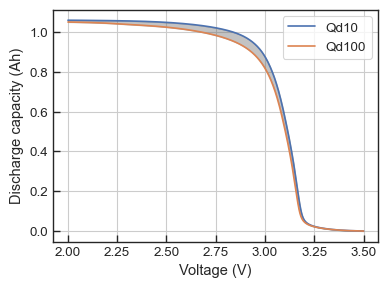

In [13]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(v, Qd10, label='Qd10')
ax.plot(v, Qd100, label='Qd100')
ax.fill_between(v, Qd100, Qd10, color='dimgrey', alpha=0.4)
ax.legend(loc='best')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Discharge capacity (Ah)')
ax.grid(True)
fig.tight_layout()
plt.show()

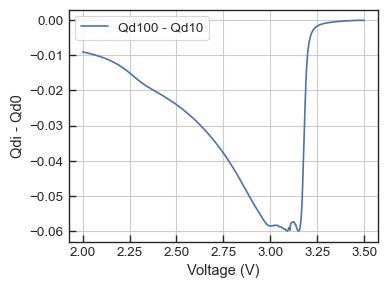

In [14]:
deltaQ = Qd100 - Qd10

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(v, deltaQ, label='Qd100 - Qd10')
ax.legend(loc='best')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Qdi - Qd0')
ax.grid(True)
fig.tight_layout()
plt.show()

In [15]:
# Statistics for the Qd100 - Qd10 curve.
dQ_stats = get_data_array_stats(deltaQ)
dQ_stats

{'min': -0.0599611066808754,
 'max': -5.922018376103576e-05,
 'mean': -0.02568300435634949,
 'std': 0.019774850635291063,
 'mode': -0.0599611066808754,
 'skew': -0.39128017608437793,
 'kurt': -1.1205085945799993,
 'median': -0.02178456313093413,
 'iqr': 0.03176063231807896}

AUC: [-0.0041, -0.0052, 0.0008, 0.0021, 0.0125, 0.0131, 0.0118, 0.0168, 0.0255, 0.0344, 0.0403, 0.0433, 0.0478, 0.0534, 0.0557, 0.0629, 0.0649, 0.0686, 0.0725]


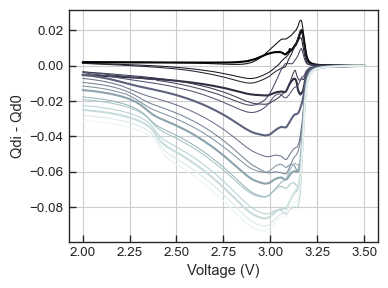

In [16]:
q0 = bat_dict[cell]['cycles'][str(1)]['Qdlin']
start, stop, step = 10, 200, 10
n_steps = int((stop - start)/step) + 1
colors = plt.cm.bone(np.linspace(0, 1, n_steps))
fig, ax = plt.subplots(figsize=(4,3))
aucs = []
k = 0
for i in range(start, stop, step):
    qi = bat_dict[cell]['cycles'][str(i)]['Qdlin']
    deltaQ = qi - q0
    aucs.append(simpson(deltaQ, x=v))
    if i in range(start, stop, 4*step):
        ax.plot(v, deltaQ, c=colors[k], lw=1.5)
    else:
        ax.plot(v, deltaQ, c=colors[k], lw=0.75)
    k += 1
print('AUC:', [a.round(4) for a in aucs])
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Qdi - Qd0')
ax.grid(True)
fig.tight_layout()
plt.show()

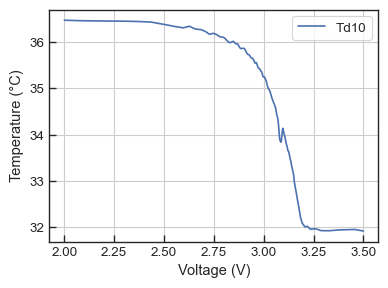

In [17]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(v, Td, label='Td10')
ax.legend(loc='best')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Temperature (°C)')
ax.grid(True)
fig.tight_layout()
plt.show()

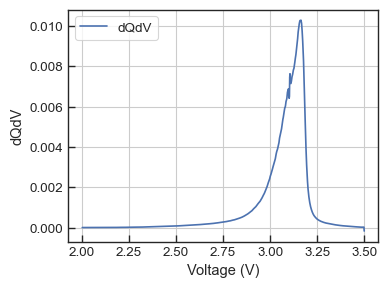

In [18]:
dQ_dV = np.diff(Qd10, prepend=0)

fig, ax = plt.subplots(figsize=(4,3))
ax.plot(v, dQ_dV, label='dQdV')
ax.legend(loc='best')
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('dQdV')
ax.grid(True)
fig.tight_layout()
plt.show()

### Regression models

Model is predicting an End-of-Life for the battery cell.

Analysis considers three sets with progressively increasing number of features. First set is called a "variance model" features and considers a single feature. Second set is called "discharge model" features and implements several features derived from cell discharge cycle and fade curves. Third set is called "full model" features and contains the most extensive set. For more information regarding these feature sets consult "Supplementary information" for the Nature Energy paper "Data-driven prediction of battery cycle life before capacity degradation".

Analysis further considers three different regression models, which can be applied with any of the three feature sets. These are (1) Penalized elastic net linear regression, (2) Generalized linear regression with a Tweedie distribution and (3) Support vector regression with a RBF kernel.

#### Features engineering

In [11]:
# Regression on battery cells End-of-Life values.
X_data, y_data = get_features_from_data(bat_dict, skip_outliers=True)

In [ ]:
# Targets are battery cell knee-points.
y_data_knees = get_knee_points(bat_dict)
for cid, eol, knee in zip(bat_dict.keys(), y_data, y_data_knees):
    if knee > eol:
        print(f'Cell ID: {cid}, Knee: {knee}, EoL: {eol}')
        print(f'Warning: {cid} knee-point is beyond the EoL!')

In [24]:
# Targets are battery cell knee-onset points.
y_data_knee_onsets = get_knee_onset_points(bat_dict)
for cid, eol, knee, knee_onset in zip(bat_dict.keys(), 
                                      y_data, y_data_knees, y_data_knee_onsets):
    if knee_onset > eol:
        print(f'Cell ID: {cid}, Knee-onset: {knee_onset}, EoL: {eol}')
        print(f'Warning: {cid} knee-onset point is beyond the EoL!')
    if knee_onset > knee:
        print(f'Cell ID: {cid}, Knee: {knee}, Knee-onset: {knee_onset}')
        print(f'Warning: {cid} knee-onset point is beyond the Knee point!')        

In [12]:
# Correlations between features and log of targets.
df = pd.DataFrame(X_data)
for col in df.columns:
    p, _ = pearsonr(X_data[col], np.log(y_data))
    # Print only significant correlations.
    if p < -0.5 or p > 0.5:
        print(f'{col}: {p:.3f}')

min: 0.758
mean: 0.782
std: -0.826
mode: 0.758
kurt: 0.589
median: 0.743
iqr: -0.915
char5: -0.937
dq_auc: -0.782
dqdv_min: 0.706
dqdv_mean: 0.542
dqdv_std: -0.676
dqdv_mode: 0.706
dqdv_skew: 0.813
dqdv_kurt: -0.798
dqdv_median: -0.612
dqdv_iqr: -0.895
dqdv_auc: -0.538


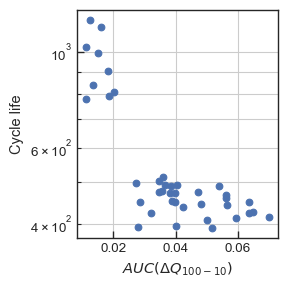

In [13]:
fig, ax = plt.subplots(figsize=(3,3))
ax.set_yscale('log')
ax.scatter(X_data['dq_auc'], y_data)
ax.set_xlabel(r'$AUC(\Delta Q_{100-10})$')
ax.set_ylabel('Cycle life')
ax.grid(which='both', axis='both')
fig.tight_layout()
plt.show()

In [14]:
# Select one of the following feature sets: 'variance', 'discharge' or 'full'.
set_of_features = 'variance'  # EDIT HERE

#### "Variance model" features

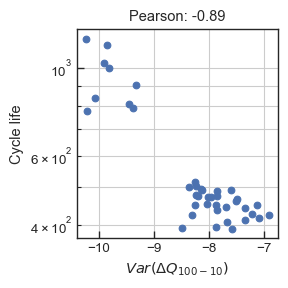

In [15]:
# Model has a single feature, which is the variance of the 
# difference between discharge curves for the 10-th and the 100-th
# cycles, i.e. Var(Q100 - Q10).
if set_of_features == 'variance':
    X_data = np.log(np.asarray(X_data['std'])**2).reshape(-1, 1)
    
    # Pearson's correlation coefficient.
    rho, _ = pearsonr(X_data.flatten(), y_data)

    fig, ax = plt.subplots(figsize=(3,3))
    ax.set_title(f'Pearson: {rho:.2f}')
    ax.set_yscale('log')
    ax.scatter(X_data, y_data)
    ax.set_xlabel(r'$Var(\Delta Q_{100-10})$')
    ax.set_ylabel('Cycle life')
    ax.grid(which='both', axis='both')
    fig.tight_layout()
    plt.show()

#### "Discharge model" features

In [24]:
# Model usues a combination of statistical features from the deltaQ
# curve (see above) and the battery cell discharge fade curve.
if set_of_features == 'discharge':
    discharge_features = ['std', 'min', 'skew', 'kurt', 'qd2', 'qd_dif']
    X_data = pd.DataFrame(X_data, columns=discharge_features)
    X_data['std'] = X_data['std'].values**2  # variance
    print(X_data.head())

#### "Full model" features

In [25]:
# Model uses a more extensive set of engineered features.
if set_of_features == 'full':
    full_features = ['std', 'min', 'qd2', 'slope', 'inter', 'char5', 
                     'rsmin', 'rsdif']
    X_data = pd.DataFrame(X_data, columns=full_features)
    X_data['std'] = X_data['std'].values**2  # variance
    print(X_data.head())

#### "Custom model" features

In [26]:
# My custom model.
if set_of_features == 'custom':
    my_features = ['min', 'std', 'mode', 'kurt', 'iqr', 'dq_auc', 
                   'slope', 'char5', 'rsmin', 'qd_dif']
    X_data = pd.DataFrame(X_data, columns=my_features)
    X_data['logvar'] = np.log(X_data['std'].values**2)  # log of variance
    print(X_data.head())

#### Train & test split

In [16]:
# Split dataset into train and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, train_size=0.8, shuffle=True)

In [17]:
# Select a regression model from: 'linear', 'tweedie' or 'svr'.
reg = 'linear'  # EDIT HERE

In [18]:
if reg == 'linear':
    # Penalized linear regression.
    reg_model = ElasticNet(max_iter=2000)
elif reg == 'tweedie':
    # Generalized linear regression with a Tweedie distribution.
    reg_model = TweedieRegressor(max_iter=200)
elif reg == 'svr':
    # Support vector machine regression.
    reg_model = svm.NuSVR(kernel='rbf')
else:
    raise NotImplementedError('Chosen model is not implemented.')

#### GridSearchCV hyperparameters optimization 

In [19]:

if reg == 'linear':
    grid = {'alpha': [0.01, 0.1, 1, 10, 50, 100, 500],
            'l1_ratio': [.1, .5, .7, .9, .95, .99, 1]}
elif reg == 'tweedie':
    grid = {'power': [1, 1.5, 2],
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
elif reg == 'svr':
    grid = {'nu': [.1, .3, .5, .7, .9, .95, .99], 
            'C': [0.1, 1, 10, 50, 100, 250, 500, 750, 1000]}
# Hyperparameters optimization with grid search and cross-validation.
model = Pipeline([
    ('scale', StandardScaler()), 
    ('model', GridSearchCV(estimator=reg_model, param_grid=grid, 
                           scoring='neg_root_mean_squared_error', 
                           cv=3, refit=True, n_jobs=-1))
])

#### Model fit & predict

In [20]:
model.fit(X_train, np.log(y_train))  # fit on log of targets

Pipeline(steps=[('scale', StandardScaler()),
                ('model',
                 GridSearchCV(cv=3, estimator=ElasticNet(max_iter=2000),
                              n_jobs=-1,
                              param_grid={'alpha': [0.01, 0.1, 1, 10, 50, 100,
                                                    500],
                                          'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95,
                                                       0.99, 1]},
                              scoring='neg_root_mean_squared_error'))])

In [21]:
model['model'].best_params_

{'alpha': 0.1, 'l1_ratio': 0.1}

In [22]:
# Predicted values.
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred)  # return with exp back to targets
print(y_pred.round(0))

[504. 405. 494. 467. 390. 522. 711. 380.]


In [23]:
# Actual values.
print(y_test)

[492 442 452 489 426 503 904 450]


#### RMSE and MAPE

In [24]:
rmse = root_mean_squared_error(y_test, y_pred)
print(f'RMSE: {rmse:.2f} cycles')

RMSE: 77.14 cycles


In [25]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape*100:.2f} %')

MAPE: 9.22 %


#### SHAP analysis

In [37]:
if reg == 'linear':
    # Penalized linear regression.
    final_model = ElasticNet(**model['model'].best_params_)
elif reg == 'tweedie':
    # Generalized linear regression with a Tweedie distribution.
    final_model = TweedieRegressor(**model['model'].best_params_)
elif reg == 'svr':
    # Support vector machine regression.
    final_model = svm.NuSVR(kernel='rbf', **model['model'].best_params_)
else:
    raise NotImplementedError('Chosen model is not implemented.')
# Refit final model for explaining (with optimal hyperparameters).
final_model.fit(X_train, np.log(y_train))
# Create a general Explainer instance from the model (using training data).
explainer = shap.KernelExplainer(final_model.predict, X_train)

In [ ]:
# Feature importance (average from the test set).
shap.plots.bar(explainer(X_test), max_display=8)

In [ ]:
# Individual features importance from the test set.
shap.plots.beeswarm(explainer(X_train), max_display=8)

In [ ]:
shap.plots.waterfall(explainer(X_test)[0])  # explaining the first test sample

### Processing of summary data

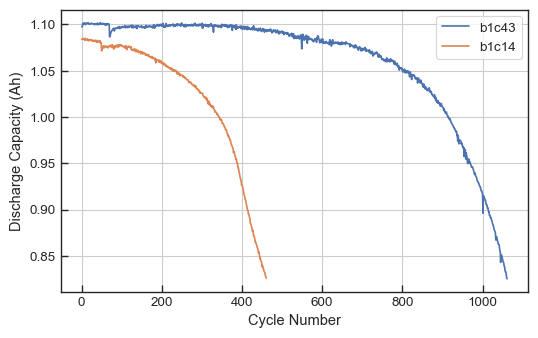

In [41]:
fig, ax = plt.subplots(figsize=(5.5,3.5))
for cid in ['b1c43', 'b1c14']:
    ax.plot(bat_dict[cid]['summary']['cycle'], 
            bat_dict[cid]['summary']['QD'], 
            label=cid)
ax.set_xlabel('Cycle Number')
ax.set_ylabel('Discharge Capacity (Ah)')
ax.legend(loc='best')
ax.grid(which='major', axis='both')
fig.tight_layout()
plt.show()

In [42]:
bat_dict[cell]['summary'].keys()

dict_keys(['IR', 'QC', 'QD', 'Tavg', 'Tmin', 'Tmax', 'chargetime', 'cycle'])

In [43]:
xi = bat_dict[cell]['summary']['cycle']  # cycles (index)
qd = bat_dict[cell]['summary']['QD']     # discharge capacity (Ah)

In [44]:
# Smooth data with a Savitzky-Golay filter, after
# removing outliers.
yhat = filter_signal(qd)

In [45]:
low, high = 2, 300  # Linear fit of the filtered data.
a0, ai = interpolate_signal(xi, yhat, low, high)
yi = ai * xi[low:high] + a0

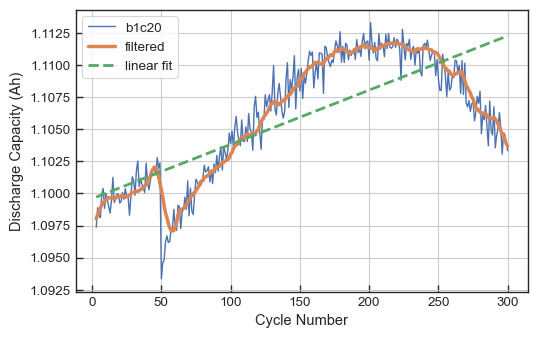

In [46]:
fig, ax = plt.subplots(figsize=(5.5,3.5))
ax.plot(xi[low:high], qd[low:high], lw=1, label=cell)
ax.plot(xi[low:high], yhat[low:high], lw=2.5, label='filtered')
ax.plot(xi[low:high], yi, ls='--', lw=2, label='linear fit')
ax.set_xlabel('Cycle Number')
ax.set_ylabel('Discharge Capacity (Ah)')
ax.grid(which='major', axis='both')
ax.legend(loc='best')
fig.tight_layout()
plt.show()

### Bacon-Watts models

In [47]:
# Bacon-Watts model (knee-point detection).
p0 = [1, -1e-4, -1e-4, 0.7*len(yhat)]
popt_single, confint_single = fit_bacon_watts_model(xi, yhat, p0, 
                                                    model_type='single')
print('Knee point at cycle:', int(popt_single[3]))

# Double Bacon-Watts model (knee-point onset prediction).
p0 = [1, -1e-4, -1e-4, -1e-4, 0.6*len(yhat), 1.1*len(yhat)]
popt, confint = fit_bacon_watts_model(xi, yhat, p0)
print('Knee point onset at cycle:', int(popt[4]))

Knee point at cycle: 401
Knee point onset at cycle: 424


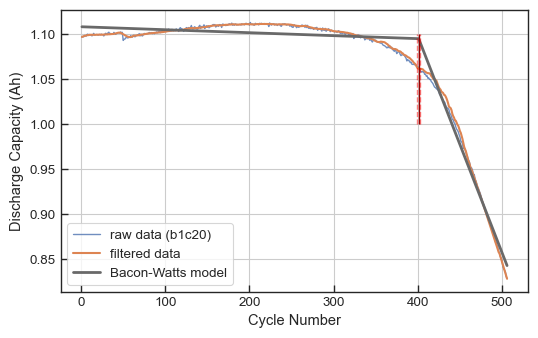

In [48]:
fig, ax = plt.subplots(figsize=(5.5,3.5))
ax.plot(xi, qd, lw=1, alpha=0.8, label=f'raw data ({cell})')
ax.plot(xi, yhat, lw=1.5, label='filtered data')
ax.plot(xi, bacon_watts_model(xi, *popt_single), 
        c='dimgrey', lw=2, label='Bacon-Watts model')
ax.vlines(popt_single[3], 1, 1.1, color='darkred', lw=1)
ax.vlines(confint_single[0], 1, 1.1, color='red', alpha=0.5, lw=1, ls='--')
ax.vlines(confint_single[1], 1, 1.1, color='red', alpha=0.5, lw=1, ls='--')
ax.set_xlabel('Cycle Number')
ax.set_ylabel('Discharge Capacity (Ah)')
ax.grid(which='major', axis='both')
ax.legend(loc='lower left')
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5.5,3.5))
ax.plot(xi, qd, lw=1, alpha=0.8, label=f'raw data ({cell})')
ax.plot(xi, yhat, lw=1.5, label='filtered data')
ax.plot(xi, double_bacon_watts_model(xi, *popt), 
        c='dimgrey', lw=2, label='Double Bacon-Watts model')
ax.vlines(popt[4], 1.05, 1.1, color='darkred', lw=1)
ax.vlines(confint[0], 1.05, 1.1, color='red', alpha=0.5, lw=1, ls='--')
ax.vlines(confint[1], 1.05, 1.1, color='red', alpha=0.5, lw=1, ls='--')
ax.set_xlabel('Cycle Number')
ax.set_ylabel('Discharge Capacity (Ah)')
ax.legend(loc='lower left')
ax.grid(which='major', axis='both')
fig.tight_layout()
plt.show()

### JSON Dataset

In [ ]:
with open('qd_capacity_data.json', 'r') as fp:
    qd_capacity_dict = json.load(fp)

x_data = np.arange(len(qd_capacity_dict[cell])) + 1
y_data = qd_capacity_dict[cell]

In [ ]:
fig, ax = plt.subplots(figsize=(5.5,3.5))
ax.plot(x_data, y_data, label=cell)
ax.grid(which='major', axis='both')
ax.set_xlabel('Cycle Number')
ax.legend(loc='best')
fig.tight_layout()
plt.show()